<a href="https://colab.research.google.com/github/gigihArmy/chatbot_lstm_DL/blob/main/tes_lstm_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import random
import string
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Bidirectional, Conv1D, MaxPooling1D, GRU

In [2]:
!wget https://raw.githubusercontent.com/gigihArmy/chatbot_lstm_DL/refs/heads/main/dataset_dl.json -O data.json

# Membaca file JSON
import json

with open('data.json') as f:
    data = json.load(f)
    print(data)

--2025-01-05 12:25:26--  https://raw.githubusercontent.com/gigihArmy/chatbot_lstm_DL/refs/heads/main/dataset_dl.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111460 (109K) [text/plain]
Saving to: ‘data.json’

data.json           100%[===================>] 108.85K  --.-KB/s    in 0.009s  

2025-01-05 12:25:26 (11.9 MB/s) - ‘data.json’ saved [111460/111460]

{'intens': [{'tag': 'salam', 'patterns': ['Halo', 'Hai', 'Selamat pagi', 'Selamat siang', 'Apa kabar?', 'Halo cui', 'Halo rek', 'Halo bro apa kabar', 'Selamat sore', 'Selamat malam', 'Apa kabar?', 'Gimana kabarmu?', 'Apa yang bisa saya bantu?', 'Apa yang sedang kamu lakukan?', 'Selamat datang', 'Apa yang sedang terjadi?', 'Hallo', 'Hey', 'Hi, apa kabar?', 'Apa kabar hari ini?', 'Kamu baik-baik saja?

In [3]:
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
#Mendapatkan semua data dalam list
tags = []
inputs = []
responses = {}
words = []
classes = []
documents = []
ignore_words = ['?', '!']

for intent in data['intens']:
  responses[intent['tag']] = intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))

      if intent['tag'] not in classes:
        classes.append(intent['tag'])

In [5]:
#Split dataset
X_train, X_test, y_train, y_test = train_test_split(inputs, tags, test_size=0.2, random_state=20)
train_data = pd.DataFrame({"patterns": X_train, "tags": y_train})
test_data = pd.DataFrame({"patterns": X_test, "tags": y_test})

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952 entries, 0 to 951
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   patterns  952 non-null    object
 1   tags      952 non-null    object
dtypes: object(2)
memory usage: 15.0+ KB


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   patterns  238 non-null    object
 1   tags      238 non-null    object
dtypes: object(2)
memory usage: 3.8+ KB


In [8]:
train_data.describe()

,patterns,tags
count,952,952
unique,944,44
top,Selamat siang,madilog_pengertian
freq,2,75


In [9]:
test_data.describe()

,patterns,tags
count,238,238
unique,238,39
top,Apa yang membuat Tan Malaka tertarik untuk bel...,madilog_kritik
freq,1,18


In [10]:
train_data.head()

,patterns,tags
0,Kamu baik-baik saja?,salam
1,Bagaimana cara memahami isi Madilog?,madilog_pengertian
2,"Kurang ngerti, bisa dijelasin lagi?",bantuan
3,Kok sejarah Tan Malaka kurang populer?,tan_malaka_kurang_dikenal
4,Kenapa Tan Malaka sampai menulis buku Madilog?,madilog_kritik


In [11]:
test_data.head()

,patterns,tags
0,Apa yang membuat Tan Malaka tertarik untuk bel...,tan_malaka_pendidikan
1,"Dulu, siapa Tan Malaka di Indonesia?",tan_malaka_biografi
2,"Waktunya berpisah, semoga kita masih bisa bert...",perpisahan
3,Jam di sini dan di sana sama nggak?,waktu
4,Apakah Madilog menyinggung golongan tertentu?,madilog_kritik


In [12]:
train_data['patterns'] = train_data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
train_data['patterns'] = train_data['patterns'].apply(lambda wrd: ''.join(wrd))
test_data['patterns'] = test_data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
test_data['patterns'] = test_data['patterns'].apply(lambda wrd: ''.join(wrd))

In [13]:
#inisialisasi lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
  tokens = nltk.word_tokenize(text)
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
  lemmatized_text = ' '.join(lemmatized_tokens)
  return lemmatized_text

train_data['patterns'] = train_data['patterns'].apply(lemmatize_text)
test_data['patterns'] = test_data['patterns'].apply(lemmatize_text)

In [14]:
#Tokenisasi Data
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(train_data['patterns'])

X_train = tokenizer.texts_to_sequences(train_data['patterns'])
X_test = tokenizer.texts_to_sequences(test_data['patterns'])

In [15]:
#Apply Padding
max_sequence_length = max(len(seq) for seq in X_train + X_test)
X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

In [16]:
#Kombinasi tag dari train_data dan test_data
all_tags = list(set(train_data['tags']) | set(test_data['tags']))

le = LabelEncoder()
le.fit(all_tags)

y_train = le.transform(train_data['tags'])
y_test = le.transform(test_data['tags'])

In [17]:
train_dataset = (X_train, y_train)
test_dataset = (X_test, y_test)

In [18]:
import requests

# URL untuk pretrained FastText embeddings bahasa Indonesia
url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz"

# Nama file untuk menyimpan hasil unduhan
output_file = "cc.id.300.vec.gz"

print("Downloading FastText embeddings for Indonesian...")
response = requests.get(url, stream=True)

with open(output_file, "wb") as file:
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:
            file.write(chunk)

print(f"FastText embeddings downloaded and saved as {output_file}")


FastText embeddings downloaded and saved as cc.id.300.vec.gz


In [19]:
import gzip
import shutil

# File yang diunduh
compressed_file = "cc.id.300.vec.gz"
extracted_file = "cc.id.300.vec"

print("Extracting FastText embeddings...")
with gzip.open(compressed_file, "rb") as f_in:
    with open(extracted_file, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

print(f"File extracted and saved as {extracted_file}")


Extracting FastText embeddings...
File extracted and saved as cc.id.300.vec


In [20]:
# Melihat beberapa baris pertama dari file
with open("cc.id.300.vec", "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        print(line.strip())
        if i >= 5:  # Cetak 5 baris pertama
            break


2000000 300
, 0.0183 -0.0404 -0.0395 0.1229 0.0618 0.0565 -0.0779 -0.0407 -0.0291 0.0576 0.0657 -0.0430 -0.0021 -0.0458 -0.0132 0.0089 -0.0113 0.0401 0.0180 -0.0375 0.0785 0.0343 -0.0198 -0.0528 -0.0672 0.0253 0.0055 -0.0146 -0.3152 -0.0715 0.1358 0.0030 -0.0072 -0.0426 -0.0688 0.0144 -0.0659 0.0574 0.0455 0.0627 0.0093 -0.0405 -0.0428 -0.0014 -0.0373 -0.0410 -0.1958 -0.0225 -0.0270 -0.0086 -0.0368 -0.0131 -0.0343 0.3139 -0.0489 0.0225 -0.1792 -0.0570 0.1698 -0.0275 0.0008 0.0186 -0.0361 0.0036 0.0356 -0.0258 0.0205 -0.0130 0.0609 -0.0564 0.0818 -0.0085 0.0117 -0.0182 -0.0567 0.0169 -0.0649 0.0420 -0.0049 -0.0469 -0.0438 0.0168 0.0049 -0.0019 -0.0086 -0.0399 0.0553 0.1233 -0.0834 0.0228 0.0380 0.0788 0.1494 0.0223 -0.0073 -1.0348 -0.0141 -0.0839 0.0066 -0.0121 -0.0218 0.0307 0.0266 0.0165 -0.0789 -0.0476 -0.0421 0.0650 0.0017 -0.0051 0.0138 0.1108 0.0192 0.0312 0.0101 0.0154 -0.0734 0.0402 0.0107 -0.0304 0.0464 0.0296 0.0664 -0.0754 0.0293 -0.0405 -0.0370 -0.0597 -0.0431 -0.0367 -0.014

In [21]:
# Path ke file hasil ekstraksi
fasttext_file_path = "cc.id.300.vec"

# Dimensi embedding FastText
embedding_dim = 300

# Membaca file FastText embeddings
embeddings_index = {}
with open(fasttext_file_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

print(f"Loaded {len(embeddings_index)} word vectors from FastText.")

Loaded 2000000 word vectors from FastText.


In [22]:
# Membuat matriks embedding untuk kata-kata dalam tokenizer
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector  # Gunakan vector FastText jika tersedia


In [23]:
#Model
regularization = regularizers.l2(0.01)

#Dropout
dropout_rate = 0.5

#Input layer
input_layer = Input(shape=(max_sequence_length,))

#Embedding layer
#embedding_size = 10
#x = Embedding(len(tokenizer.word_index) + 1, embedding_size)(input_layer)

# Embedding layer dengan pretrained FastText
embedding_layer = Embedding(
    input_dim=len(tokenizer.word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],  # Gunakan pretrained FastText weights
    input_length=max_sequence_length,
    trainable=False  # Set False agar tidak melatih ulang embedding
)(input_layer)

#LSTM layer
lstm_units = 16
x = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding_layer)

#Gru layer
#ru_units = 32
#x = Bidirectional(GRU(gru_units, return_sequences=True))(x)

#Flatten layer
x = Flatten()(x)

#Dense layer
dense_units = 50
x = Dense(dense_units, activation='relu')(x)
x = Dropout(dropout_rate)(x)

#Output layer
num_classes = len(classes)
x = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=x)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 12, 300)             │         227,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 12, 32)              │          40,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │          19,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 44)                  │           2,244 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 289,170 (1.10 MB)

 Trainable params: 62,070 (242.46 KB)

 Non-trainable params: 227,100 (887.11 KB)

In [24]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.7):
      print("\nValidasi Akurasi telah mencapai 70%, stop training")

      self.model.stop_training = True

In [25]:
cb = myCallback()
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
#Train model
history = model.fit(train_dataset[0], train_dataset[1], batch_size=32, epochs=300, callbacks=[cb], validation_data=test_dataset)

Epoch 1/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.0376 - loss: 3.7816 - val_accuracy: 0.0462 - val_loss: 3.7745
Epoch 2/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0346 - loss: 3.7744 - val_accuracy: 0.0756 - val_loss: 3.7656
Epoch 3/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0584 - loss: 3.7649 - val_accuracy: 0.0882 - val_loss: 3.7524
Epoch 4/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.0805 - loss: 3.7505 - val_accuracy: 0.0966 - val_loss: 3.7333
Epoch 5/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0919 - loss: 3.7225 - val_accuracy: 0.0588 - val_loss: 3.7027
Epoch 6/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0947 - loss: 3.6848 - val_accuracy: 0.0546 - val_loss: 3.6599
Epoch 7/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.0874 - loss: 3.6348 - val_accuracy: 0.0588 - val_loss: 3.6060
Epoch 8/300
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.0726 - loss: 3.5956 - val_accuracy: 0.

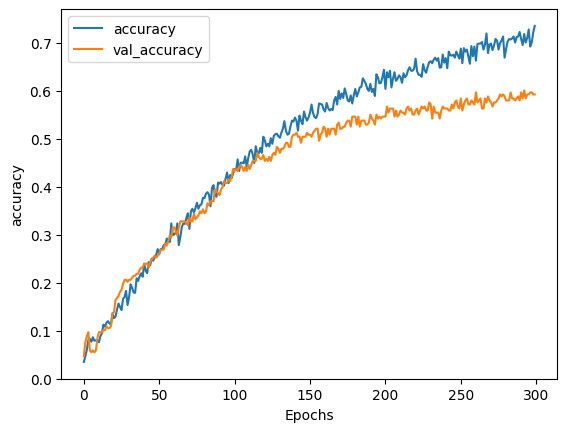

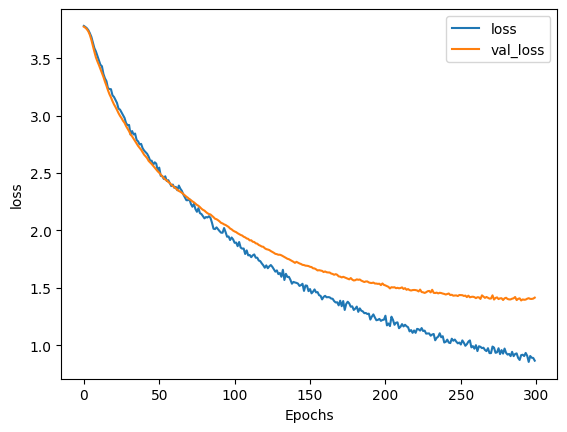

In [27]:
#Vis akurasi dan loss
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [30]:
#chat input
while True:
  texts = []
  prediction_input = input("Anda: ")

  #hapus punk dan lowercase
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts.append(prediction_input)

  #tokenisasi dan padding
  prediction_input = tokenizer.texts_to_sequences(texts)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input], maxlen=max_sequence_length)

  output = model.predict(prediction_input)
  output = output.argmax()

  response_tag = le.inverse_transform([output])[0]
  print("ChatBot: ", random.choice(responses[response_tag]))
  if response_tag == "perpisahan":
    break

Anda: halo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
ChatBot:  Hai kawan! Bagaimana saya bisa membantu Anda?
Anda: siapa itu tan malaka?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
ChatBot:  Tan Malaka adalah seorang pemimpin revolusioner dan intelektual asal Indonesia yang lahir pada 2 Juni 1897 di Nagari Pandan Gadang, Sumatera Barat.
Anda: dimana tan malaka sekolah?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
ChatBot:  Pada masa muda, Tan Malaka menuntut ilmu di sekolah-sekolah Belanda dan kemudian melanjutkan pendidikannya di Eropa, yang sangat memengaruhi cara pandangnya tentang dunia.
Anda: apa perjuangan tan malaka bagi indonesia?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
ChatBot:  Tan Malaka meninggalkan ide besar seperti Madilog, yang mengajarkan logika, materialisme, dan dialektika untuk membangun cara berpikir kritis.
Anda: apa itu madilog?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
ChatBot:  Tujuan utama dari Madilog adalah membimbing masyarakat Indonesia untuk berpikir logis, memahami materialisme